# $CO$ MODEL

The aim of this model is to train a Machine Learning Regression Model to predict air $CO$ molecule concentration.

### Libraries

In [2]:
#Data
import pandas as pd
import numpy as np
#-------------------------------------------------------

#Visualization
import seaborn as sns
import matplotlib.pyplot as plt
#-------------------------------------------------------
#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#-------------------------------------------------------

# XGBoost
import xgboost as xgb
from xgboost import XGBRegressor
#-------------------------------------------------------

# Linear Models
from sklearn.linear_model import LinearRegression
#-------------------------------------------------------

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report
#-------------------------------------------------------

# Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV
#-------------------------------------------------------

# Others
import joblib
#-------------------------------------------------------



## Data Cleaning and Analysis

In [3]:
names = [f'../data/CO/daily_42101_{year}.csv' for year in range(2010, 2026)]
data_raw = pd.concat([pd.read_csv(name) for name in names], ignore_index=True)
data_raw

FileNotFoundError: [Errno 2] No such file or directory: '../data/CO/daily_42101_2010.csv'

Let us obtain the columns we want.

In [ ]:
columns=['Latitude','Longitude','Date Local','Arithmetic Mean']
data_pre_date=data_raw[columns].copy()
data_pre_date

,Latitude,Longitude,Date Local,Arithmetic Mean
0,33.529444,-86.850278,2010-01-01,0.470833
1,33.529444,-86.850278,2010-01-02,0.479167
2,33.529444,-86.850278,2010-01-03,0.462500
3,33.529444,-86.850278,2010-01-04,0.579167
4,33.529444,-86.850278,2010-01-05,0.582609
...,...,...,...,...
3002263,18.198712,-66.052237,2025-03-28,0.200000
3002264,18.198712,-66.052237,2025-03-29,0.175000
3002265,18.198712,-66.052237,2025-03-30,0.200000
3002266,18.198712,-66.052237,2025-03-31,0.229167


Check for missing values.

In [ ]:
data_pre_date.isna().sum()

Latitude           0
Longitude          0
Date Local         0
Arithmetic Mean    0
dtype: int64

In [ ]:
df=data_pre_date.copy()

Additional Adjusts.

Due to measure noise, it is possible to have negative concentrations. Let's set them to 0.

In [ ]:
df['Arithmetic Mean'] = df['Arithmetic Mean'].clip(lower=0)
df

,Latitude,Longitude,Date Local,Arithmetic Mean
0,33.529444,-86.850278,2010-01-01,0.470833
1,33.529444,-86.850278,2010-01-02,0.479167
2,33.529444,-86.850278,2010-01-03,0.462500
3,33.529444,-86.850278,2010-01-04,0.579167
4,33.529444,-86.850278,2010-01-05,0.582609
...,...,...,...,...
3002263,18.198712,-66.052237,2025-03-28,0.200000
3002264,18.198712,-66.052237,2025-03-29,0.175000
3002265,18.198712,-66.052237,2025-03-30,0.200000
3002266,18.198712,-66.052237,2025-03-31,0.229167


Removing Outliers.

We need to consider latitudes, longitudes and dates are within a fixed range. As a result, only outliers in the predicted variable ('Arithmetic Mean') will be eliminated. 

<Axes: xlabel='Arithmetic Mean'>

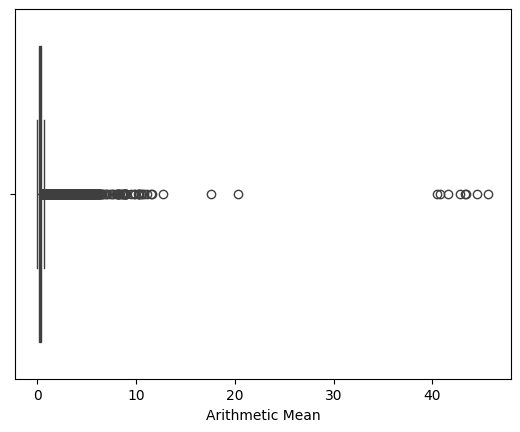

In [ ]:
sns.boxplot(data=df, x='Arithmetic Mean')

In [ ]:
outliers = set()
col='Arithmetic Mean'

q1 = np.nanquantile(df[col],0.25)
q3 = np.nanquantile(df[col],0.75)
iqr = q3-q1
upper_lim = q3+(1.5*iqr)
lower_lim = q1-(1.5*iqr)

outliers.update(df[(df[col] > upper_lim) | (df[col] < lower_lim)].index)

#print(len(outliers))
#outliers

In [ ]:
df = df.drop(index=outliers).reset_index(drop=True)
df

,Latitude,Longitude,Date Local,Arithmetic Mean
0,33.529444,-86.850278,2010-01-01,0.470833
1,33.529444,-86.850278,2010-01-02,0.479167
2,33.529444,-86.850278,2010-01-03,0.462500
3,33.529444,-86.850278,2010-01-04,0.579167
4,33.529444,-86.850278,2010-01-05,0.582609
...,...,...,...,...
2860788,18.198712,-66.052237,2025-03-28,0.200000
2860789,18.198712,-66.052237,2025-03-29,0.175000
2860790,18.198712,-66.052237,2025-03-30,0.200000
2860791,18.198712,-66.052237,2025-03-31,0.229167


## XGBoost

Adjust the date to correct format.

In [ ]:
# Transforming to desired format
df['Date Local']=pd.to_datetime(df['Date Local'],format="%Y-%m-%d")

#Applying sin, cos coding
df['Year']=df['Date Local'].dt.year
df['Month']=df['Date Local'].dt.month
df['Day']=df['Date Local'].dt.dayofyear

df['Month_sin']=np.sin(2*np.pi*df['Month']/12)
df['Month_cos']=np.cos(2*np.pi*df['Month']/12)

df['Day_sin']=np.sin(2*np.pi*df['Day']/365)
df['Day_cos']=np.cos(2*np.pi*df['Day']/365)

df.drop(['Date Local', 'Month', 'Day'], axis=1, inplace=True)
df

,Latitude,Longitude,Arithmetic Mean,Year,Month_sin,Month_cos,Day_sin,Day_cos
0,33.529444,-86.850278,0.470833,2010,0.500000,8.660254e-01,0.017213,0.999852
1,33.529444,-86.850278,0.479167,2010,0.500000,8.660254e-01,0.034422,0.999407
2,33.529444,-86.850278,0.462500,2010,0.500000,8.660254e-01,0.051620,0.998667
3,33.529444,-86.850278,0.579167,2010,0.500000,8.660254e-01,0.068802,0.997630
4,33.529444,-86.850278,0.582609,2010,0.500000,8.660254e-01,0.085965,0.996298
...,...,...,...,...,...,...,...,...
2860788,18.198712,-66.052237,0.200000,2025,1.000000,6.123234e-17,0.997325,0.073095
2860789,18.198712,-66.052237,0.175000,2025,1.000000,6.123234e-17,0.998435,0.055917
2860790,18.198712,-66.052237,0.200000,2025,1.000000,6.123234e-17,0.999250,0.038722
2860791,18.198712,-66.052237,0.229167,2025,1.000000,6.123234e-17,0.999769,0.021516


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2860793 entries, 0 to 2860792
Data columns (total 8 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Latitude         float64
 1   Longitude        float64
 2   Arithmetic Mean  float64
 3   Year             int32  
 4   Month_sin        float64
 5   Month_cos        float64
 6   Day_sin          float64
 7   Day_cos          float64
dtypes: float64(7), int32(1)
memory usage: 163.7 MB


### Training

In [ ]:
# ================================
target = "Arithmetic Mean"
features = [col for col in df.columns if col != target]

X = df[features]
y = df[target]
# ================================

# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# ================================


# ================================
model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist",
    n_jobs=-1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)
# ================================

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

### Test and Evaluation

MAE : 0.0820
RMSE: 0.1087
R²  : 0.4687


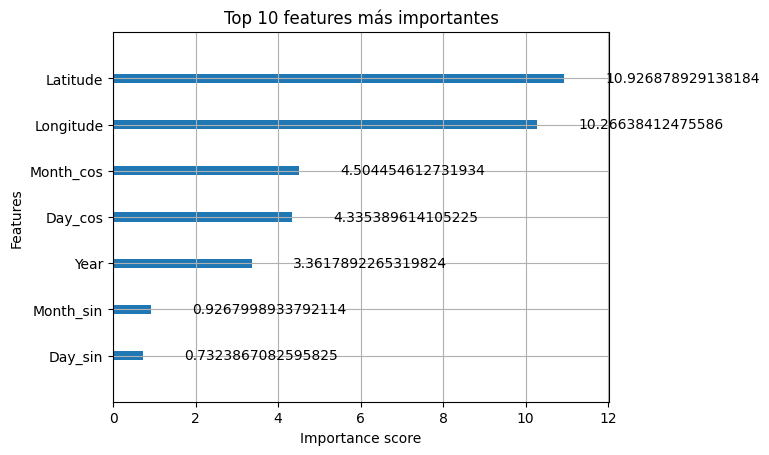

In [ ]:
# ================================
# Predictions
y_pred = model.predict(X_test)
# ================================


# ================================
# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")
# ================================


# ================================
# Feature Importance
xgb.plot_importance(model, importance_type="gain", max_num_features=10)
plt.title("Top 10 features más importantes")
plt.show()
# ================================


### Hyperparameter Tuning

<!-- Esta sección ha sido comentada temporalmente. -->

In [ ]:
# ================================
# HYPERPARAMETER TUNING COMENTADO
# ================================
# param_dist = {
#     'n_estimators': np.arange(100, 1001, 100),
#     'max_depth': np.arange(3, 11, 1),
#     'learning_rate': np.linspace(0.01, 0.3, 10),
#     'subsample': np.linspace(0.5, 1.0, 4),
#     'colsample_bytree': np.linspace(0.5, 1.0, 4),
#     'gamma': np.linspace(0, 5, 4),
#     'reg_alpha': np.linspace(0, 1, 4),
#     'reg_lambda': np.linspace(1, 10, 5)
# }
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_dist,
#     n_iter=5,
#     scoring='neg_mean_squared_error',
#     cv=2,
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )
# random_search.fit(X_train, y_train)


In [ ]:
# ================================
# HYPERPARAMETER TUNING COMENTADO
# ================================
# print("Best hyperparameters:", random_search.best_params_)
# print("Best score (neg-MSE):", random_search.best_score_)
# best_model = random_search.best_estimator_
# y_pred = best_model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)
# print(f"RMSE en test: {rmse:.4f}")
# print(f"R² en test: {r2:.4f}")


## Linear Regression

In [ ]:
# ================================
# LINEAR REGRESSION COMENTADO
# ================================
# Entrenamiento
# linear_model = LinearRegression()
# linear_model.fit(X_train, y_train)

# Predicción
# y_pred_linear = linear_model.predict(X_test)

# Métricas
# mae_linear = mean_absolute_error(y_test, y_pred_linear)
# rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
# r2_linear = r2_score(y_test, y_pred_linear)

# print(f"MAE (Linear): {mae_linear:.4f}")
# print(f"RMSE (Linear): {rmse_linear:.4f}")
# print(f"R² (Linear): {r2_linear:.4f}")

# Importancia de características (coeficientes)
# plt.figure(figsize=(8,4))
# plt.bar(X_train.columns, linear_model.coef_)
# plt.title("Importancia de características (Linear Regression)")
# plt.xticks(rotation=45)
# plt.show()


In [ ]:
# ================================
# HYPERPARAMETER TUNING LINEAR REGRESSION COMENTADO
# ================================
# from sklearn.model_selection import GridSearchCV

# Definir el espacio de búsqueda de hiperparámetros
# param_grid = {
#     'fit_intercept': [True, False],
#     'copy_X': [True, False],
#     'positive': [True, False],
#     # 'normalize': [True, False]  # Solo disponible en versiones antiguas de sklearn
# }

# Configurar GridSearchCV
# linear_search = GridSearchCV(
#     estimator=LinearRegression(),
#     param_grid=param_grid,
#     scoring='neg_mean_squared_error',
#     cv=5,
#     verbose=2,
#     n_jobs=-1
# )

# Ejecutar la búsqueda
# grid_result = linear_search.fit(X_train, y_train)

# Resultados
# print("Mejores hiperparámetros:", grid_result.best_params_)
# print("Mejor score (neg-MSE):", grid_result.best_score_)

# Evaluación en test
# best_linear = grid_result.best_estimator_
# y_pred_best_linear = best_linear.predict(X_test)
# mse_best_linear = mean_squared_error(y_test, y_pred_best_linear)
# rmse_best_linear = np.sqrt(mse_best_linear)
# r2_best_linear = r2_score(y_test, y_pred_best_linear)
# print(f"RMSE en test (Linear): {rmse_best_linear:.4f}")
# print(f"R² en test (Linear): {r2_best_linear:.4f}")


## Model Deployment

In [ ]:
joblib.dump(model, "../models/CO_model.pkl")

['../models/CO_model.pkl']

## Model Visualization

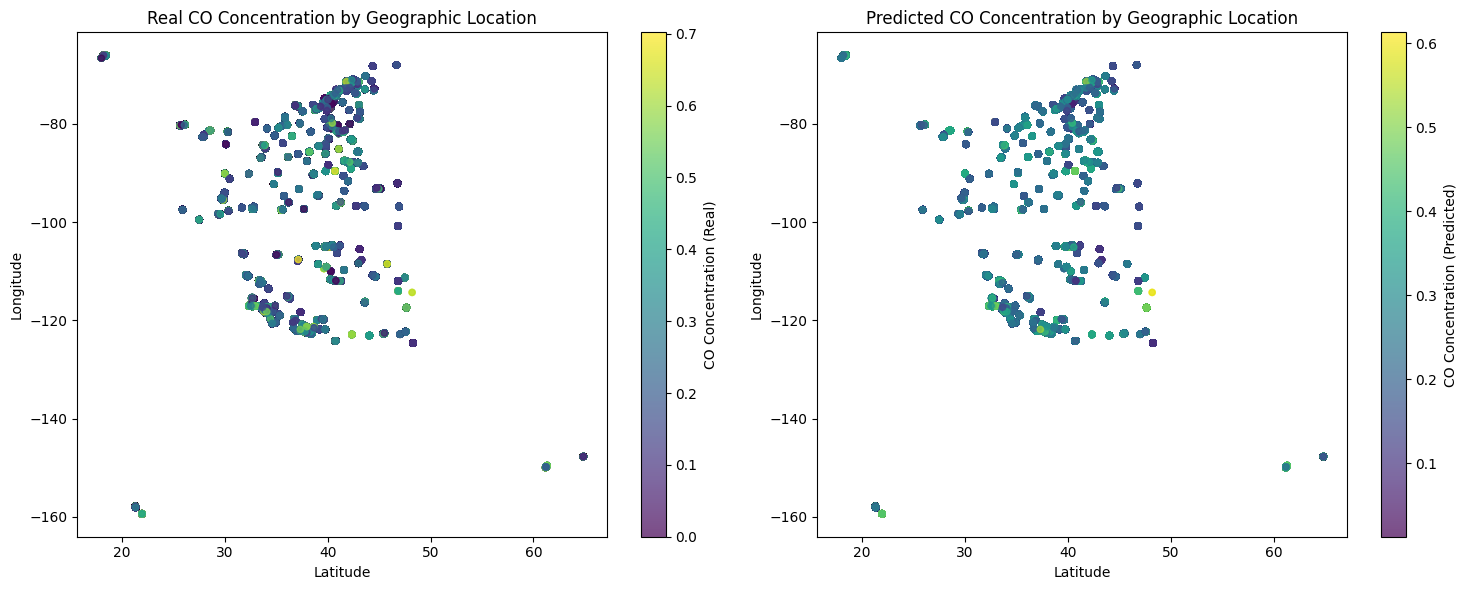

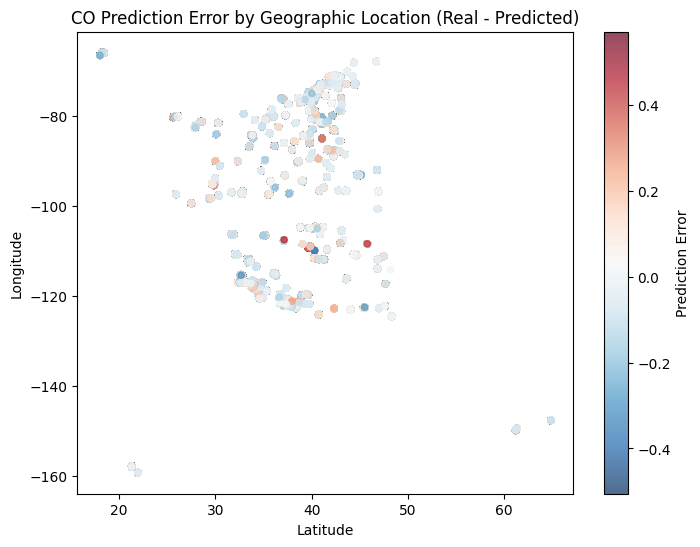

Images saved successfully in ../images/ directory:
- CO_real_vs_predicted_heatmaps.png
- CO_prediction_error_heatmap.png


In [ ]:
# Geographic heatmaps: Real vs Predicted CO concentration
import matplotlib.pyplot as plt
import numpy as np
import os

# Create images directory if it doesn't exist
os.makedirs('../images', exist_ok=True)

# Get latitude and longitude from test set
lat_test = X_test['Latitude'].values
lon_test = X_test['Longitude'].values

# Create figure with subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Map 1: Real CO concentration
scatter1 = ax1.scatter(lat_test, lon_test, c=y_test, cmap='viridis', s=20, alpha=0.7)
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')
ax1.set_title('Real CO Concentration by Geographic Location')
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('CO Concentration (Real)')

# Map 2: Predicted NO2 concentration
scatter2 = ax2.scatter(lat_test, lon_test, c=y_pred, cmap='viridis', s=20, alpha=0.7)
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Longitude')
ax2.set_title('Predicted CO Concentration by Geographic Location')
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('CO Concentration (Predicted)')

plt.tight_layout()
plt.savefig('../images/CO_real_vs_predicted_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

# Difference map (optional): Shows prediction errors geographically
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
diff = y_test.values - y_pred
scatter3 = ax.scatter(lat_test, lon_test, c=diff, cmap='RdBu_r', s=20, alpha=0.7)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_title('CO Prediction Error by Geographic Location (Real - Predicted)')
cbar3 = plt.colorbar(scatter3, ax=ax)
cbar3.set_label('Prediction Error')
plt.savefig('../images/CO_prediction_error_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Images saved successfully in ../images/ directory:")
print("- CO_real_vs_predicted_heatmaps.png")
print("- CO_prediction_error_heatmap.png")